In [1]:
import sys
sys.path.append('../../')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import argparse
import os

import warnings
warnings.filterwarnings('ignore')

/Users/machi/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Intialise initial
* INIT_LR = Learning rate
* EPOCHS = Number of epoch to train
* BS = Batch size

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32


### Load dataset


In [3]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images('../dataset'))
data = []
labels = []

for imagePath in imagePaths:
    # remove class label from the path
    label = imagePath.split(os.path.sep)[-2]
    
    # load input image(224x224) and preprocess
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    # update the data and labels list
    data.append(image)
    labels.append(label)

[INFO] loading images...


### Convert and label data to numpy

In [4]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Split train and test data

In [5]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

### Construct training image generator for data augmentation

In [6]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

### Load MobileNetV2 network and construct head of the model

In [7]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

### Place the head FC model on top of the base model
- loop over the layer in the base model and freeze them to ensure they no be updated during the 1st training process
- compile the model

In [8]:
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

## Train and predict

### Train the head of the network


In [9]:
print("Training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training head...
Epoch 1/20
96/96 [==============================] - 65s 678ms/step - loss: 0.3506 - accuracy: 0.8403 - val_loss: 0.1019 - val_accuracy: 0.9806
Epoch 2/20
96/96 [==============================] - 69s 719ms/step - loss: 0.1226 - accuracy: 0.9559 - val_loss: 0.0713 - val_accuracy: 0.9845
Epoch 3/20
96/96 [==============================] - 68s 706ms/step - loss: 0.1018 - accuracy: 0.9641 - val_loss: 0.0731 - val_accuracy: 0.9819
Epoch 4/20
96/96 [==============================] - 65s 682ms/step - loss: 0.0783 - accuracy: 0.9729 - val_loss: 0.0566 - val_accuracy: 0.9897
Epoch 5/20
96/96 [==============================] - 65s 675ms/step - loss: 0.0556 - accuracy: 0.9807 - val_loss: 0.0530 - val_accuracy: 0.9897
Epoch 6/20
96/96 [==============================] - 65s 674ms/step - loss: 0.0518 - accuracy: 0.9824 - val_loss: 0.0517 - val_accuracy: 0.9897
Epoch 7/20
96/96 [==============================] - 64s 670ms/step - loss: 0.0547 - accuracy: 0.9827 - val_loss: 0.0495 - val

### Predict the network

In [10]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


### Training result visualization

In [11]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       388
without_mask       0.99      0.99      0.99       386

    accuracy                           0.99       774
   macro avg       0.99      0.99      0.99       774
weighted avg       0.99      0.99      0.99       774



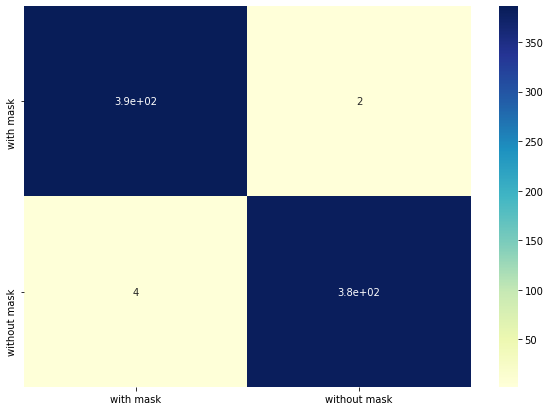

In [12]:
# show a classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
result_cm = pd.DataFrame(cm, index = [i for i in ["with mask",'without mask']],columns = [i for i in ["with mask",'without mask']])
plt.figure(figsize = (10,7))
sn.heatmap(result_cm, annot=True,cmap="YlGnBu")
plt.savefig("confusion_matrix.png")

### Save model to disk

In [13]:
print("[INFO] saving mask detector model...")
model.save('../model/nn_model.h5', save_format="h5")

[INFO] saving mask detector model...


## Plot training loss and accuracy

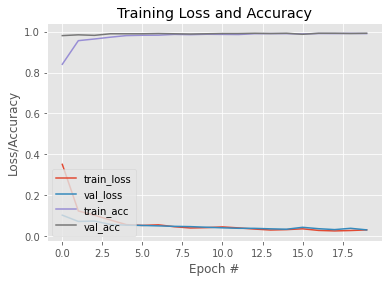

In [14]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('training.png')

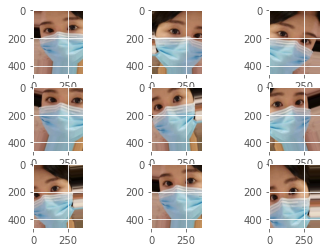

<Figure size 432x288 with 0 Axes>

In [15]:
from numpy import expand_dims
from matplotlib import pyplot
img = load_img('../dataset/with_mask/0_0_0066ichXly3gbb630i4w6j30u00tzjtk.jpg')

# convert to numpy array
data = img_to_array(img)
# preprocess = preprocess_input(image)
samples = expand_dims(data, 0)
# create image data augmentation generator
# datagen = ImageDataGenerator(height_shift_range=0.5)
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()
pyplot.savefig('data_augmentation.png')